# Sequential Workflow

## Bmi Calculator

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [2]:
# define state
class BMIState(TypedDict):

    weight_kg: float
    height_m: float
    bmi: float
    category: str

In [3]:
def calculate_bmi(state: BMIState) -> BMIState:

    weight = state['weight_kg']
    height = state['height_m']

    bmi = weight/(height**2)

    state['bmi'] = round(bmi, 2)

    return state

In [4]:
def label_bmi(state: BMIState) -> BMIState:

    bmi = state['bmi']

    if bmi < 18.5:
        state["category"] = "Underweight"
    elif 18.5 <= bmi < 25:
        state["category"] = "Normal"
    elif 25 <= bmi < 30:
        state["category"] = "Overweight"
    else:
        state["category"] = "Obese"

    return state

In [5]:
# define your graph
graph = StateGraph(BMIState)

# add nodes to your graph
graph.add_node('calculate_bmi', calculate_bmi)
graph.add_node('label_bmi', label_bmi)

# add edges to your graph
graph.add_edge(START, 'calculate_bmi')
graph.add_edge('calculate_bmi', 'label_bmi')
graph.add_edge('label_bmi', END)


# compile the graph
workflow = graph.compile()

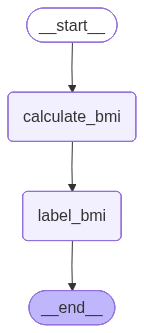

In [6]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [7]:
# execute the graph
intial_state = {'weight_kg':80, 'height_m':1.73}

final_state = workflow.invoke(intial_state)

print(final_state)

{'weight_kg': 80, 'height_m': 1.73, 'bmi': 26.73, 'category': 'Overweight'}


## LLM 

In [8]:
from langchain.chat_models import init_chat_model
from langchain.messages import HumanMessage, ToolMessage, AIMessage

model = init_chat_model(
    model="functiongemma:latest",
    model_provider="ollama",
    temperature = 0.0
)

In [9]:
class LLMState(TypedDict):

    question: str
    answer: str

In [10]:
def llm_qa(state: LLMState) -> LLMState:

    # extract the question from state
    question = state['question']

    # form a prompt
    prompt = f'Answer the following question {question}'

    # ask that question to the LLM
    answer = model.invoke(prompt).content

    # update the answer in the state
    state['answer'] = answer

    return state

In [11]:
# create our graph

graph = StateGraph(LLMState)

# add nodes
graph.add_node('llm_qa', llm_qa)

# add edges
graph.add_edge(START, 'llm_qa')
graph.add_edge('llm_qa', END)

# compile
workflow = graph.compile()

In [12]:
# execute

intial_state = {'question': 'How far is moon from the earth?'}

final_state = workflow.invoke(intial_state)

print(final_state['answer'])

The Earth is approximately 34,400 miles away from the Moon.


## Prompt Chaining

In [18]:
from langchain.chat_models import init_chat_model
from langchain.messages import HumanMessage, ToolMessage, AIMessage

model = init_chat_model(
    model="qwen2.5-coder:7b",
    model_provider="ollama",
    temperature = 0.0
)

In [19]:
class BlogState(TypedDict):

    title: str
    outline: str
    content: str

In [20]:
def create_outline(state: BlogState) -> BlogState:

    # fetch title
    title = state['title']

    # call llm gen outline
    prompt = f'Generate a detailed outline for a blog on the topic - {title}'
    outline = model.invoke(prompt).content

    # update state
    state['outline'] = outline

    return state

In [21]:
def create_blog(state: BlogState) -> BlogState:

    title = state['title']
    outline = state['outline']

    prompt = f'Write a detailed blog on the title - {title} using the follwing outline \n {outline}'

    content = model.invoke(prompt).content

    state['content'] = content

    return state

In [22]:
graph = StateGraph(BlogState)

# nodes
graph.add_node('create_outline', create_outline)
graph.add_node('create_blog', create_blog)

# edges
graph.add_edge(START, 'create_outline')
graph.add_edge('create_outline', 'create_blog')
graph.add_edge('create_blog', END)

workflow = graph.compile()

In [23]:
intial_state = {'title': 'Rise of AI in India'}

final_state = workflow.invoke(intial_state)

print(final_state)

{'title': 'Rise of AI in India', 'outline': "I. Introduction to Artificial Intelligence (AI) in India\n\nA. Brief history and evolution of AI\nB. Current state of AI in India\nC. Importance of AI in the Indian economy and society\n\nII. Government Initiatives and Policies Supporting AI in India\n\nA. National Strategy for Artificial Intelligence\nB. Department of Science and Technology's initiatives\nC. Start-up ecosystem and funding opportunities\nD. Regulatory frameworks and ethical considerations\n\nIII. Applications of AI in Various Industries in India\n\nA. Healthcare\n1. Telemedicine and remote patient monitoring\n2. Medical diagnosis and treatment planning\n3. Drug discovery and personalized medicine\nB. Finance\n1. Fraud detection and prevention\n2. Robo-advisors and automated investment management\n3. Customer service and chatbots\nC. Manufacturing\n1. Predictive maintenance and quality control\n2. Supply chain optimization\n3. Autonomous vehicles and robotics\nD. Agriculture\